### Question 1

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

attack_category = ['normal', 'DOS', 'R2L', 'U2R', 'probe']
normal = ['normal']
DOS = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
probe = ['ipsweep','mscan','nmap','portsweep','saint','satan']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0 if name in DOS else 2.0 if name in R2L else 3.0 if name in U2R else 4.0 if name in probe else 5.0)  # Unknown category or any other category not listed
        label_to_category = udf(lambda name: attack_category[0] if name == 0.0 else attack_category[1] if name == 1.0 else attack_category[2] if name == 2.0 else attack_category[3] if name == 3.0 else attack_category[4] if name == 4.0 else 'NA')  # Unknown category or any other category not listed        
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")    
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.withColumn('outcome_category',label_to_category(col('outcome')))
        output_df = output_df.withColumn('outcome_category', col('outcome_category').cast(StringType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 


import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('/Users/kiranprasadjp/Downloads/NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('/Users/kiranprasadjp/Downloads/NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 23:33:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/09 23:33:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
nslkdd_df.printSchema()
nslkdd_df.show()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- outcome_category: string (nullable = true)

+--------------------+-------+----------------+
|            features|outcome|outcome_category|
+--------------------+-------+----------------+
|(113,[1,13,14,17,...|    0.0|          normal|
|(113,[1,13,14,17,...|    0.0|          normal|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[1,2,13,14,1...|    0.0|          normal|
|(113,[1,2,13,14,1...|    0.0|          normal|
|(113,[13,14,16,17...|    1.0|             DOS|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[13,14,16,17...|    1.0|             DOS|
|(113,[13,14,15,17...|    1.0|             DOS|
|(113,[1,2,13,14,1...|    0.0|          normal|
|(113,[1,13,14,17,...|    2.0|             R2L|
|(113,[13,14,15,18...|    1.0|             DOS|
|(1

In [3]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Imputer, StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Convert Spark DataFrames to Pandas DataFrames
nslkdd_pd = nslkdd_df.toPandas()
nslkdd_test_pd = nslkdd_df_test.toPandas()

# Split the data into training, validation, and testing sets
# 50% of KDDTest+ for validation and the remaining 50% for testing
split_ratio = 0.5
split_index = int(len(nslkdd_test_pd) * split_ratio)

validation_data = nslkdd_test_pd[:split_index]
test_data = nslkdd_test_pd[split_index:]


In [4]:
x_train = torch.from_numpy(np.array(nslkdd_pd['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_pd['outcome'].values.tolist(),np.int64))
x_validate = torch.from_numpy(np.array(validation_data['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(validation_data['outcome'].values.tolist(),np.int64))
x_test = torch.from_numpy(np.array(test_data['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(test_data['outcome'].values.tolist(),np.int64))

### Question 2

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x[idx],self.y[idx])

train_dataset = MyDataset(x_train,y_train)
validate_dataset = MyDataset(x_validate,y_validate)
test_dataset = MyDataset(x_test,y_test)

In [6]:
import torch.nn as nn

class myMultilayerPerceptron(nn.Module):
    def __init__(self,input_dm,output_dm):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dm,226),
            nn.Tanh(),
            nn.Linear(226,113),
            nn.Tanh(),
            nn.Linear(113,56),
            nn.Tanh(),
            nn.Linear(56,28),
            nn.ReLU(),
            nn.Linear(28,output_dm)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y

In [7]:
mymodel = myMultilayerPerceptron(x_train.shape[1],5)
print(mymodel)

myMultilayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=226, bias=True)
    (1): Tanh()
    (2): Linear(in_features=226, out_features=113, bias=True)
    (3): Tanh()
    (4): Linear(in_features=113, out_features=56, bias=True)
    (5): Tanh()
    (6): Linear(in_features=56, out_features=28, bias=True)
    (7): ReLU()
    (8): Linear(in_features=28, out_features=5, bias=True)
  )
)


### Question 3 (Note: Metric chosen = accuracy)

In [8]:
# hyperparameters
lr = 0.05 
batch_size = 64
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]


Epoch=0,train_loss=0.1759623885154724,validate_loss=1.3685113191604614
Train_accuracy=95.65%,validate_accuracy=70.05%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.2158375233411789,validate_loss=1.3289837837219238
Train_accuracy=94.85%,validate_accuracy=66.67%
Epoch=2,train_loss=0.24386034905910492,validate_loss=1.3362921476364136
Train_accuracy=93.91%,validate_accuracy=71.26%
Current epoch is best so far, saving model...
Epoch=3,train_loss=0.2443723976612091,validate_loss=1.551171898841858
Train_accuracy=93.1%,validate_accuracy=70.75%
Epoch=4,train_loss=0.23730111122131348,validate_loss=1.6409270763397217
Train_accuracy=93.28%,validate_accuracy=69.01%
Epoch=5,train_loss=0.2012268602848053,validate_loss=1.4399733543395996
Train_accuracy=95.15%,validate_accuracy=67.63%
Epoch=6,train_loss=0.21134880185127258,validate_loss=1.335500955581665
Train_accuracy=94.17%,validate_accuracy=69.94%
Epoch=7,train_loss=0.2258778214454651,validate_loss=1.8142789602279663
Train_accur

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

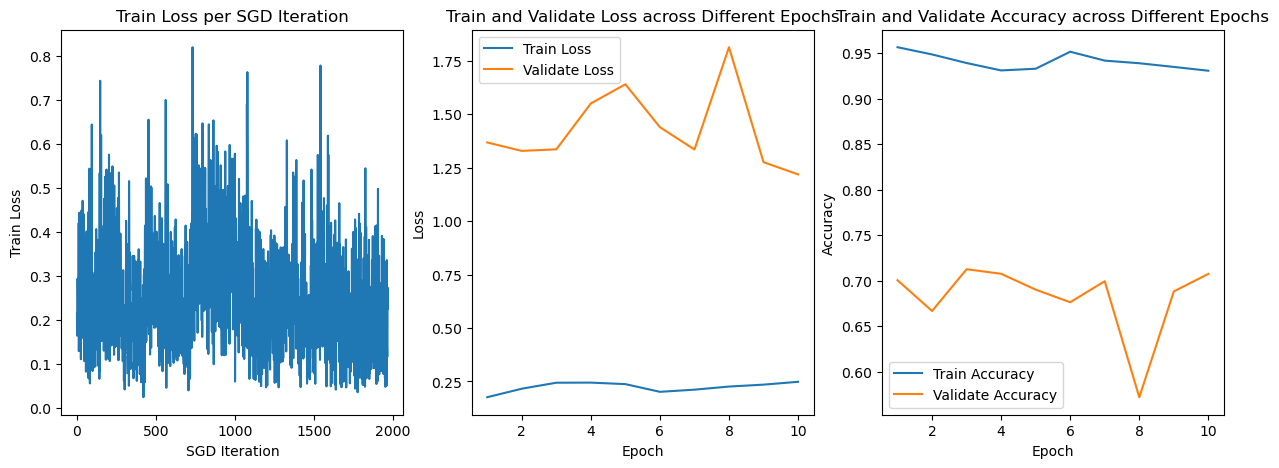

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

### Question 4

***Note: I have purposely chose hyperparamters before that gives high loss so that I now when i hypertune the model, the convergence,loss and accuracy has stark improvement.***

##### Steps I followed to hypertune:
1. Increased number of epochs - In this step i could see a lot of fluctuations in my metric - accuracy.
2. Increased batch size - In this step I could see that the fluctuations in accuracy were eliminated, but there was still one notcieable jump in accuracy metric. 
3. Decreased learning ratio - In this step, i could see that fluctuations in accuracy were eliminated and accuracy curve was relatively smooth.
4. From the above steps I learnt that for the following data, tuning learning ratio improved the accuracy metric the most.
5. To get the final hypertuned parameter, I Increased batch size, decreased learning ratio and kept the number of epochs as same comapred to the hyperparameters we used in Q3.

***Note: I'm aware, the validation loss does not decrease, and it is due to the fact that the two data sets we took are vastly different.***

#### However for the assignment purpose, to hypertune and fit my data even more, I increased the batch size, number of epochs and decreased the learning rate.

In [10]:
# hyperparameters
lr = 0.05 
batch_size = 64
N_epochs = 25

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]


Epoch=0,train_loss=0.20059753954410553,validate_loss=2.1363370418548584
Train_accuracy=94.95%,validate_accuracy=72.03%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.1914178431034088,validate_loss=1.431452751159668
Train_accuracy=95.76%,validate_accuracy=72.27%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.1780841201543808,validate_loss=1.3532395362854004
Train_accuracy=96.46%,validate_accuracy=72.44%
Current epoch is best so far, saving model...
Epoch=3,train_loss=0.1903146207332611,validate_loss=1.3609135150909424
Train_accuracy=95.4%,validate_accuracy=71.11%
Epoch=4,train_loss=0.19908231496810913,validate_loss=1.6711556911468506
Train_accuracy=95.36%,validate_accuracy=70.63%
Epoch=5,train_loss=0.24685172736644745,validate_loss=1.258803367614746
Train_accuracy=93.42%,validate_accuracy=64.42%
Epoch=6,train_loss=0.2543299198150635,validate_loss=1.5087683200836182
Train_accuracy=93.74%,validate_accuracy=61.7%
Epoch=7,train_loss=0.2517766356468200

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

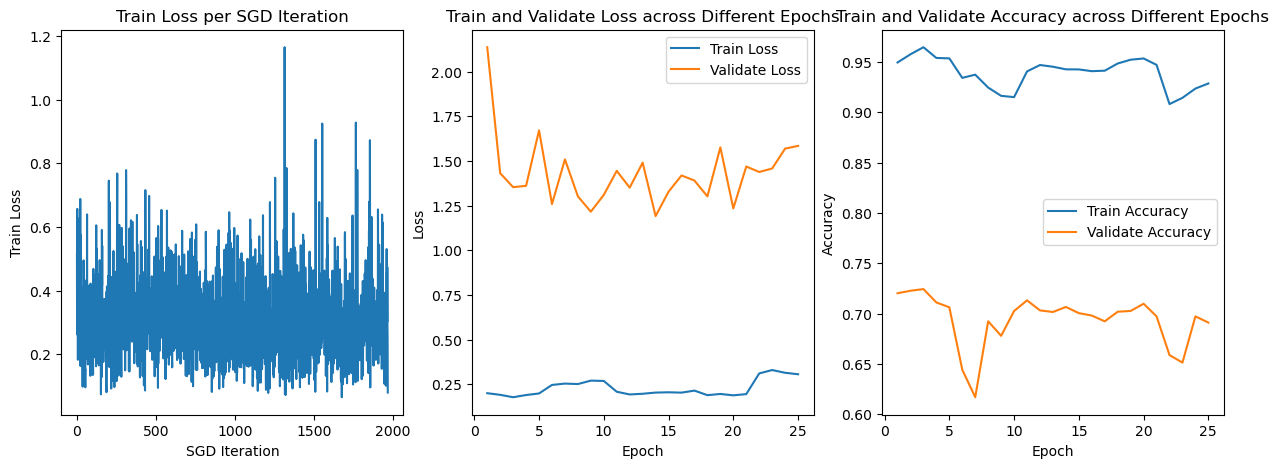

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

In [12]:
# hyperparameters
lr = 0.05 
batch_size = 128
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]


Epoch=0,train_loss=0.2910799980163574,validate_loss=1.3877204656600952
Train_accuracy=93.29%,validate_accuracy=70.57%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.2885233461856842,validate_loss=1.3361672163009644
Train_accuracy=93.29%,validate_accuracy=70.35%
Epoch=2,train_loss=0.29518038034439087,validate_loss=1.4966228008270264
Train_accuracy=93.39%,validate_accuracy=70.6%
Current epoch is best so far, saving model...
Epoch=3,train_loss=0.2995074987411499,validate_loss=1.3447386026382446
Train_accuracy=93.13%,validate_accuracy=69.45%
Epoch=4,train_loss=0.30262491106987,validate_loss=1.558706521987915
Train_accuracy=93.25%,validate_accuracy=71.4%
Current epoch is best so far, saving model...
Epoch=5,train_loss=0.2863333225250244,validate_loss=1.5161794424057007
Train_accuracy=93.7%,validate_accuracy=70.51%
Epoch=6,train_loss=0.29376354813575745,validate_loss=1.3480241298675537
Train_accuracy=93.25%,validate_accuracy=69.51%
Epoch=7,train_loss=0.293213427066803,val

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

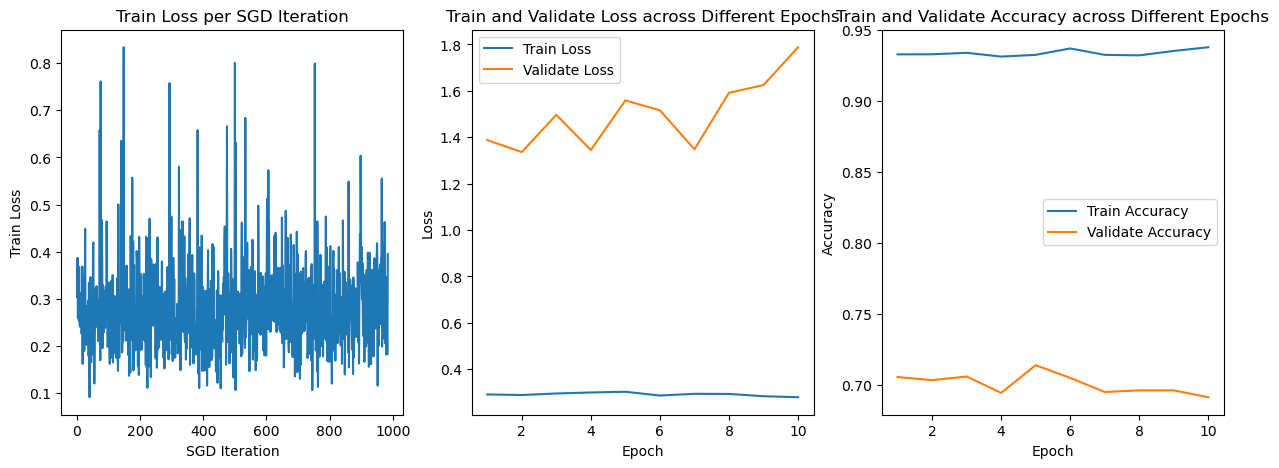

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

In [14]:
# hyperparameters
lr = 0.004 
batch_size = 64
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]


Epoch=0,train_loss=0.27251654863357544,validate_loss=1.7364015579223633
Train_accuracy=93.93%,validate_accuracy=69.32%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.27061983942985535,validate_loss=1.7642725706100464
Train_accuracy=93.99%,validate_accuracy=69.7%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.2697236239910126,validate_loss=1.750284194946289
Train_accuracy=94.06%,validate_accuracy=69.92%
Current epoch is best so far, saving model...
Epoch=3,train_loss=0.26899194717407227,validate_loss=1.7135013341903687
Train_accuracy=94.11%,validate_accuracy=70.04%
Current epoch is best so far, saving model...
Epoch=4,train_loss=0.26821571588516235,validate_loss=1.754568338394165
Train_accuracy=94.13%,validate_accuracy=70.04%
Epoch=5,train_loss=0.2683529555797577,validate_loss=1.7138054370880127
Train_accuracy=94.18%,validate_accuracy=70.6%
Current epoch is best so far, saving model...
Epoch=6,train_loss=0.2658140957355499,validate_loss=1.73554944

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

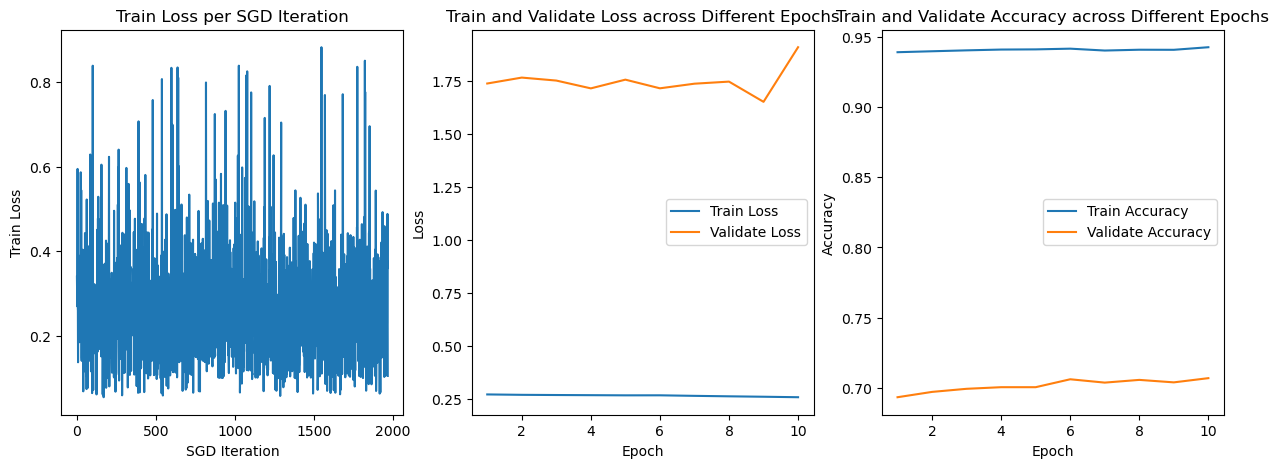

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

In [16]:
# hyperparameters
lr = 0.004 
batch_size = 128
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]


Epoch=0,train_loss=0.2561247944831848,validate_loss=1.9544044733047485
Train_accuracy=94.42%,validate_accuracy=70.45%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.256153404712677,validate_loss=1.8697177171707153
Train_accuracy=94.48%,validate_accuracy=70.79%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.2590375244617462,validate_loss=1.8650269508361816
Train_accuracy=94.42%,validate_accuracy=70.65%
Epoch=3,train_loss=0.25350040197372437,validate_loss=1.9021462202072144
Train_accuracy=94.55%,validate_accuracy=70.65%
Epoch=4,train_loss=0.2543175518512726,validate_loss=1.893886923789978
Train_accuracy=94.51%,validate_accuracy=70.47%
Epoch=5,train_loss=0.2550358772277832,validate_loss=1.9063626527786255
Train_accuracy=94.49%,validate_accuracy=70.43%
Epoch=6,train_loss=0.2574337124824524,validate_loss=1.849932074546814
Train_accuracy=94.47%,validate_accuracy=70.82%
Current epoch is best so far, saving model...
Epoch=7,train_loss=0.25794756412506104

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

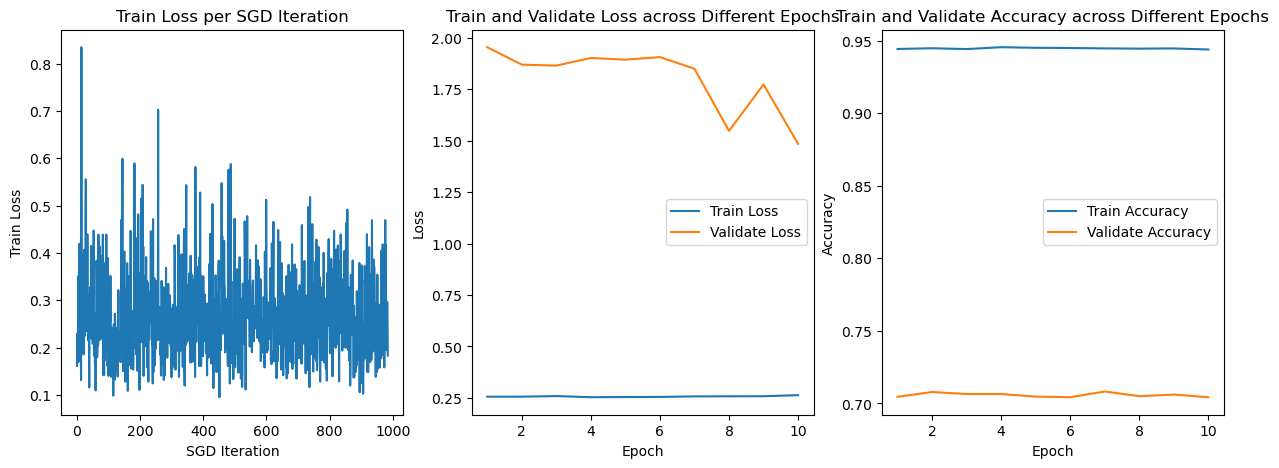

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

### Question 5 (Note: Metric chosen = accuracy)

In [18]:
# Load the best model
mybestmodel = myMultilayerPerceptron(x_train.shape[1],5)
mybestmodel.load_state_dict(torch.load("current_best_model"))

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
test_batch_accuracy = []

for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
    test_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])

test_accuracy = np.mean(np.array(validate_batch_accuracy))

print(f"Test accuracy = {np.round(test_accuracy*100,2)}%")

Test accuracy = 70.43%
